In [1]:
!pip install astroquery lightkurve

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/41.2 kB ? eta -:--:--
     ---------------------------------------- 41.2/41.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   --- ------------------------------------ 0.4/5.3 MB 12.2 MB/s eta 0:00:01
   ----- ---------------------------------- 0.8/5.3 MB 9.6 MB/s eta 0:00:01
   ------- -----

In [2]:
#Librerias que se utilizaran
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import glob
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
import datetime
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error


# Librerias astrofisica
# =============================================================================
from astroquery.mast import Observations
from astropy.timeseries import aggregate_downsample
import lightkurve as lk
from astropy.timeseries import TimeSeries
from astropy.units import Quantity
from astropy.time import Time
from astropy.table import Table
import astropy.units as u

In [3]:
Periods = pd.read_csv("cumulative_2024.07.26_22.47.20.csv", 
                      skiprows=20, header=0)[['kepid', 'koi_period', 'koi_time0bk']]

fechas_koi = Time(Periods['koi_time0bk'], format='bkjd')
Periods['koi_time0bk'] = fechas_koi.datetime 
Periods_quantity = [Quantity(value, u.day) for value in Periods['koi_period'] ]
Periods['koi_period'] = Periods_quantity
Periods

,kepid,koi_period,koi_time0bk
0,10797460,9.48803557 d,2009-06-21 00:55:48.000000
1,10797460,54.4183827 d,2009-06-13 00:19:55.776000
2,10811496,19.89913995 d,2009-06-26 08:24:21.772800
3,10848459,1.736952453 d,2009-06-20 19:22:53.616000
4,10854555,2.525591777 d,2009-06-22 02:17:35.520000
...,...,...,...
9559,10090151,0.527698548 d,2009-05-13 04:55:20.035200
9560,10128825,1.73984941 d,2009-05-14 12:01:49.728000
9561,10147276,0.681401611 d,2009-05-13 16:21:43.200000
9562,10155286,333.486169 d,2009-06-04 02:45:36.864000


In [4]:
period_max = max(Periods['koi_period'])
period_mean = Periods['koi_period'].mean() 
period_min = min(Periods['koi_period'])
print(f'Periodo máximo: {period_max}\nPeriodo promedio: {period_mean}\nPeriodo mínimo: {period_min}')

Periodo máximo: 129995.7784 d
Periodo promedio: 75.67135842482388 d
Periodo mínimo: 0.241842544 d


In [31]:
def Lector(URL:str):
    '''URL: Es un estring con la dirección y el nombre de la curva de luz, 
            例 Test/0/LC_6666.csv
       Esta función recibe el url de una curva de luz y la regresa como un objeto
       tipo TimeSeries de astropy'''
    #Se lee el data frame
    DF = pd.read_csv(URL)
    
    #Se cambian los formatos de la curva de luz a los deseados
    TIME = Time(list(DF['time'].values), format='iso')
    DF['flux'] = DF['flux'].astype(np.float32)
    
    #Se extrae solo la información de interes
    DataDict = {col: DF[col].values for col in DF.columns if col not in 
                 ['time', 'time_diff', 'flux_woutTrend']}
    
    #Creacion del TimeSeries de astropy
    TS = TimeSeries(time=TIME, data=DataDict)
                    
    return TS

def PhaseFolded(ts, Periods, K_id: int):
    '''ts: Objeto tipo TimeSeries
       Periods: DataFrame con información de los periodos de las curvas de luz
       K_id: Kepler ID de la estrella, debe ser un entero
       Esta función agarra una curva de luz y realiza un phase folding conociendo
       su periodo de transito'''
    
    #Se extrae de un DataFrame el periodo de la curva
    period = Periods.loc[Periods['kepid'] == K_id]['koi_period'].iloc[0].astype('float32')
    #Se extrae el momento en que empieza el transito
    transit_epoch = Periods.loc[Periods['kepid'] == K_id]['koi_time0bk'].iloc[0]
    #Se realiza el folded
    ts_folded = ts.fold( period = period, epoch_time = transit_epoch)
    
    return ts_folded

def BinsMethod(ts_folded, Periods, K_id: int):
    '''ts_folded: Curva de luz foleada, es un objeto tipo TimeSeries
       Periods: DataFrame con información de los periodos de las curvas de luz
       K_id: Kepler ID de la estrella, debe ser un entero
       Esta funcion realiza el metodo de beans que consiste en realizar
       un promedio sobre un cierto numero de bins para regresar una curva
       de longitud de 7500'''
    #Lector del periodo
    period = Periods.loc[Periods['kepid'] == K_id]['koi_period'].iloc[0].astype('float32')
    #Realización del metodo de bins
    ts_binned = aggregate_downsample(ts_folded, time_bin_size=(period/1000))  
    
    return ts_binned

In [6]:
ruta_test_0 = '../Datos_Exoplanetas/0/Test'
ruta_train_0 = '../Datos_Exoplanetas/0/Train'
ruta_val_0 = '../Datos_Exoplanetas/0/Validation'
ruta_test_1 = '../Datos_Exoplanetas/1/Test'
ruta_train_1 = '../Datos_Exoplanetas/1/Train'
ruta_val_1 = '../Datos_Exoplanetas/1/Validation'

arch_test_0 = os.listdir(ruta_test_0)
arch_train_0 = os.listdir(ruta_train_0)
arch_val_0 = os.listdir(ruta_val_0)

arch_test_1 = os.listdir(ruta_test_1)
arch_train_1 = os.listdir(ruta_train_1)
arch_val_1 = os.listdir(ruta_val_1)

n_test_0 = len(arch_test_0)
n_train_0 = len(arch_train_0)
n_val_0 = len(arch_val_0)
                        
n_test_1 = len(arch_test_1)
n_train_1 = len(arch_train_1)
n_val_1 = len(arch_val_1)

In [16]:
(n_test_0 + n_train_0 + n_val_0 + n_test_1 + n_train_1 + n_val_1)*execution_time/(60*60)

4.0454889738559725

In [32]:
i=0
print('Phase Foling Conjunto de prueba 0')
for arch in arch_test_0:
    i+=1
    Ts = Lector(ruta_test_0+'/'+arch)
    TsFolded = PhaseFolded(Ts, Periods,int(arch[3:-4]))
    TsBinned = BinsMethod(TsFolded,Periods,int(arch[3:-4])).to_pandas()
    TsBinned.to_csv(ruta_test_0+'/'+arch, index=False)
    if i%100: 
        print(np.round(i*100/n_test_0,2))
    else:
        continue

Phase Foling Conjunto de prueba 0
0.27
0.53
0.8
1.06
1.33
1.6
1.86
2.13
2.39
2.66
2.93
3.19
3.46
3.72
3.99
4.26
4.52
4.79
5.05
5.32
5.59
5.85
6.12
6.38
6.65
6.91
7.18
7.45
7.71
7.98
8.24
8.51
8.78
9.04
9.31
9.57
9.84
10.11
10.37
10.64
10.9
11.17
11.44
11.7
11.97
12.23
12.5
12.77
13.03
13.3
13.56
13.83
14.1
14.36
14.63
14.89
15.16
15.43
15.69
15.96
16.22
16.49
16.76
17.02
17.29
17.55
17.82
18.09
18.35
18.62
18.88
19.15
19.41
19.68
19.95
20.21
20.48
20.74
21.01
21.28
21.54
21.81
22.07
22.34
22.61
22.87
23.14
23.4
23.67
23.94
24.2
24.47
24.73
25.0
25.27
25.53
25.8
26.06
26.33
26.86
27.13
27.39
27.66
27.93
28.19
28.46
28.72
28.99
29.26
29.52
29.79
30.05
30.32
30.59
30.85
31.12
31.38
31.65
31.91
32.18
32.45
32.71
32.98
33.24
33.51
33.78
34.04
34.31
34.57
34.84
35.11
35.37
35.64
35.9
36.17
36.44
36.7
36.97
37.23
37.5
37.77
38.03
38.3
38.56
38.83
39.1
39.36
39.63
39.89
40.16
40.43
40.69
40.96
41.22
41.49
41.76
42.02
42.29
42.55
42.82
43.09
43.35
43.62
43.88
44.15
44.41
44.68
44.95
45.21
45.48

In [33]:
i=0
print('Phase Foling Conjunto de entrenamiento 0')
for arch in arch_train_0:
    i+=1
    Ts = Lector(ruta_train_0+'/'+arch)
    TsFolded = PhaseFolded(Ts, Periods,int(arch[3:-4]))
    TsBinned = BinsMethod(TsFolded,Periods,int(arch[3:-4])).to_pandas()
    TsBinned.to_csv(ruta_train_0+'/'+arch, index=False)
    if i%100:
        print(np.round(i*100/n_train_0,2))
    else:
        continue

Phase Foling Conjunto de entrenamiento 0
0.04
0.08
0.11
0.15
0.19
0.23
0.27
0.3
0.34
0.38
0.42
0.46
0.49
0.53
0.57
0.61
0.65
0.69
0.72
0.76
0.8
0.84
0.88
0.91
0.95
0.99
1.03
1.07
1.1
1.14
1.18
1.22
1.26
1.29
1.33
1.37
1.41
1.45
1.48
1.52
1.56
1.6
1.64
1.67
1.71
1.75
1.79
1.83
1.87
1.9
1.94
1.98
2.02
2.06
2.09
2.13
2.17
2.21
2.25
2.28
2.32
2.36
2.4
2.44
2.47
2.51
2.55
2.59
2.63
2.66
2.7
2.74
2.78
2.82
2.85
2.89
2.93
2.97
3.01
3.05
3.08
3.12
3.16
3.2
3.24
3.27
3.31
3.35
3.39
3.43
3.46
3.5
3.54
3.58
3.62
3.65
3.69
3.73
3.77
3.84
3.88
3.92
3.96
4.0
4.04
4.07
4.11
4.15
4.19
4.23
4.26
4.3
4.34
4.38
4.42
4.45
4.49
4.53
4.57
4.61
4.64
4.68
4.72
4.76
4.8
4.83
4.87
4.91
4.95
4.99
5.02
5.06
5.1
5.14
5.18
5.22
5.25
5.29
5.33
5.37
5.41
5.44
5.48
5.52
5.56
5.6
5.63
5.67
5.71
5.75
5.79
5.82
5.86
5.9
5.94
5.98
6.01
6.05
6.09
6.13
6.17
6.2
6.24
6.28
6.32
6.36
6.4
6.43
6.47
6.51
6.55
6.59
6.62
6.66
6.7
6.74
6.78
6.81
6.85
6.89
6.93
6.97
7.0
7.04
7.08
7.12
7.16
7.19
7.23
7.27
7.31
7.35
7.38
7.42
7.46
7.5

In [34]:
i=0
print('Phase Foling Conjunto de validación 0')
for arch in arch_val_0:
    i+=1
    Ts = Lector(ruta_val_0+'/'+arch)
    TsFolded = PhaseFolded(Ts, Periods,int(arch[3:-4]))
    TsBinned = BinsMethod(TsFolded,Periods,int(arch[3:-4])).to_pandas()
    TsBinned.to_csv(ruta_val_0+'/'+arch, index=False)
    if i%100:
        print(np.round(i*100/n_val_0,2))
    else:
        continue

Phase Foling Conjunto de validación 0
0.13
0.27
0.4
0.53
0.67
0.8
0.93
1.07
1.2
1.33
1.47
1.6
1.73
1.87
2.0
2.13
2.27
2.4
2.53
2.67
2.8
2.93
3.07
3.2
3.33
3.47
3.6
3.73
3.87
4.0
4.13
4.27
4.4
4.53
4.67
4.8
4.93
5.07
5.2
5.33
5.47
5.6
5.73
5.87
6.0
6.13
6.27
6.4
6.53
6.67
6.8
6.93
7.07
7.2
7.33
7.47
7.6
7.73
7.87
8.0
8.13
8.27
8.4
8.53
8.67
8.8
8.93
9.07
9.2
9.33
9.47
9.6
9.73
9.87
10.0
10.13
10.27
10.4
10.53
10.67
10.8
10.93
11.07
11.2
11.33
11.47
11.6
11.73
11.87
12.0
12.13
12.27
12.4
12.53
12.67
12.8
12.93
13.07
13.2
13.47
13.6
13.73
13.87
14.0
14.13
14.27
14.4
14.53
14.67
14.8
14.93
15.07
15.2
15.33
15.47
15.6
15.73
15.87
16.0
16.13
16.27
16.4
16.53
16.67
16.8
16.93
17.07
17.2
17.33
17.47
17.6
17.73
17.87
18.0
18.13
18.27
18.4
18.53
18.67
18.8
18.93
19.07
19.2
19.33
19.47
19.6
19.73
19.87
20.0
20.13
20.27
20.4
20.53
20.67
20.8
20.93
21.07
21.2
21.33
21.47
21.6
21.73
21.87
22.0
22.13
22.27
22.4
22.53
22.67
22.8
22.93
23.07
23.2
23.33
23.47
23.6
23.73
23.87
24.0
24.13
24.27
24.4
24.53

In [24]:
i=0
print('Phase Foling Conjunto de prueba 1')
for arch in arch_test_1:
    i+=1
    Ts = Lector(ruta_test_1+'/'+arch)
    TsFolded = PhaseFolded(Ts, Periods,int(arch[3:-4]))
    TsBinned = BinsMethod(TsFolded,Periods,int(arch[3:-4])).to_pandas()
    TsBinned.to_csv(ruta_test_1+'/'+arch, index=False)
    if i%100:
        print(np.round(i*100/n_test_1,2))
    else:
        continue

Phase Foling Conjunto de prueba 1
0.34
0.67
1.01
1.35
1.68
2.02
2.36
2.69
3.03
3.37
3.7
4.04
4.38
4.71
5.05
5.39
5.72
6.06
6.4
6.73
7.07
7.41
7.74
8.08
8.42
8.75
9.09
9.43
9.76
10.1
10.44
10.77
11.11
11.45
11.78
12.12
12.46
12.79
13.13
13.47
13.8
14.14
14.48
14.81
15.15
15.49
15.82
16.16
16.5
16.84
17.17
17.51
17.85
18.18
18.52
18.86
19.19
19.53
19.87
20.2
20.54
20.88
21.21
21.55
21.89
22.22
22.56
22.9
23.23
23.57
23.91
24.24
24.58
24.92
25.25
25.59
25.93
26.26
26.6
26.94
27.27
27.61
27.95
28.28
28.62
28.96
29.29
29.63
29.97
30.3
30.64
30.98
31.31
31.65
31.99
32.32
32.66
33.0
33.33
34.01
34.34
34.68
35.02
35.35
35.69
36.03
36.36
36.7
37.04
37.37
37.71
38.05
38.38
38.72
39.06
39.39
39.73
40.07
40.4
40.74
41.08
41.41
41.75
42.09
42.42
42.76
43.1
43.43
43.77
44.11
44.44
44.78
45.12
45.45
45.79
46.13
46.46
46.8
47.14
47.47
47.81
48.15
48.48
48.82
49.16
49.49
49.83
50.17
50.51
50.84
51.18
51.52
51.85
52.19
52.53
52.86
53.2
53.54
53.87
54.21
54.55
54.88
55.22
55.56
55.89
56.23
56.57
56.9
57.

In [25]:
i=0
print('Phase Foling Conjunto de entrenamiento 1')
for arch in arch_train_1:
    i+=1
    Ts = Lector(ruta_train_1+'/'+arch)
    TsFolded = PhaseFolded(Ts, Periods,int(arch[3:-4]))
    TsBinned = BinsMethod(TsFolded,Periods,int(arch[3:-4])).to_pandas()
    TsBinned.to_csv(ruta_train_1+'/'+arch, index=False)
    if i%100:
        print(np.round(i*100/n_train_1,2))
    else:
        continue

Phase Foling Conjunto de entrenamiento 1
0.05
0.1
0.14
0.19
0.24
0.29
0.34
0.39
0.43
0.48
0.53
0.58
0.63
0.68
0.72
0.77
0.82
0.87
0.92
0.97
1.01
1.06
1.11
1.16
1.21
1.25
1.3
1.35
1.4
1.45
1.5
1.54
1.59
1.64
1.69
1.74
1.79
1.83
1.88
1.93
1.98
2.03
2.08
2.12
2.17
2.22
2.27
2.32
2.36
2.41
2.46
2.51
2.56
2.61
2.65
2.7
2.75
2.8
2.85
2.9
2.94
2.99
3.04
3.09
3.14
3.19
3.23
3.28
3.33
3.38
3.43
3.47
3.52
3.57
3.62
3.67
3.72
3.76
3.81
3.86
3.91
3.96
4.01
4.05
4.1
4.15
4.2
4.25
4.3
4.34
4.39
4.44
4.49
4.54
4.58
4.63
4.68
4.73
4.78
4.87
4.92
4.97
5.02
5.07
5.12
5.16
5.21
5.26
5.31
5.36
5.41
5.45
5.5
5.55
5.6
5.65
5.69
5.74
5.79
5.84
5.89
5.94
5.98
6.03
6.08
6.13
6.18
6.23
6.27
6.32
6.37
6.42
6.47
6.52
6.56
6.61
6.66
6.71
6.76
6.81
6.85
6.9
6.95
7.0
7.05
7.09
7.14
7.19
7.24
7.29
7.34
7.38
7.43
7.48
7.53
7.58
7.63
7.67
7.72
7.77
7.82
7.87
7.92
7.96
8.01
8.06
8.11
8.16
8.2
8.25
8.3
8.35
8.4
8.45
8.49
8.54
8.59
8.64
8.69
8.74
8.78
8.83
8.88
8.93
8.98
9.03
9.07
9.12
9.17
9.22
9.27
9.31
9.36
9.41
9.46
9

In [26]:
i=0
print('Phase Foling Conjunto de validación 1')
for arch in arch_val_1:
    i+=1
    Ts = Lector(ruta_val_1+'/'+
                arch)
    TsFolded = PhaseFolded(Ts, Periods,int(arch[3:-4]))
    TsBinned = BinsMethod(TsFolded,Periods,int(arch[3:-4])).to_pandas()
    TsBinned.to_csv(ruta_val_1+'/'+arch, index=False)
    if i%100:
        print(np.round(i*100/n_val_1,2))
    else:
        continue

Phase Foling Conjunto de validación 1
0.17
0.34
0.51
0.68
0.84
1.01
1.18
1.35
1.52
1.69
1.86
2.03
2.2
2.36
2.53
2.7
2.87
3.04
3.21
3.38
3.55
3.72
3.89
4.05
4.22
4.39
4.56
4.73
4.9
5.07
5.24
5.41
5.57
5.74
5.91
6.08
6.25
6.42
6.59
6.76
6.93
7.09
7.26
7.43
7.6
7.77
7.94
8.11
8.28
8.45
8.61
8.78
8.95
9.12
9.29
9.46
9.63
9.8
9.97
10.14
10.3
10.47
10.64
10.81
10.98
11.15
11.32
11.49
11.66
11.82
11.99
12.16
12.33
12.5
12.67
12.84
13.01
13.18
13.34
13.51
13.68
13.85
14.02
14.19
14.36
14.53
14.7
14.86
15.03
15.2
15.37
15.54
15.71
15.88
16.05
16.22
16.39
16.55
16.72
17.06
17.23
17.4
17.57
17.74
17.91
18.07
18.24
18.41
18.58
18.75
18.92
19.09
19.26
19.43
19.59
19.76
19.93
20.1
20.27
20.44
20.61
20.78
20.95
21.11
21.28
21.45
21.62
21.79
21.96
22.13
22.3
22.47
22.64
22.8
22.97
23.14
23.31
23.48
23.65
23.82
23.99
24.16
24.32
24.49
24.66
24.83
25.0
25.17
25.34
25.51
25.68
25.84
26.01
26.18
26.35
26.52
26.69
26.86
27.03
27.2
27.36
27.53
27.7
27.87
28.04
28.21
28.38
28.55
28.72
28.89
29.05
29.22
29.39

In [28]:
start_time = time.time()
Ts1 = Lector("../Datos_Exoplanetas/1/Test/LC_10028792.csv")
TsFolded1 = PhaseFolded(Ts1, Periods,10028792)
TsBinned1 = BinsMethod(TsFolded1,Periods,10028792)
end_time = time.time()
# Tiempo de ejecución
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

Tiempo de ejecución: 1.128406286239624 segundos


In [30]:
TsBinned1.to_pandas()

,time_bin_size,flux
time_bin_start,,
-58 days +15:11:38.100737624,0.015298,0.379476
-58 days +15:33:39.866138015,0.015298,0.438461
-58 days +15:55:41.631538405,0.015298,0.008829
-58 days +16:17:43.396938796,0.015298,0.087982
-58 days +16:39:45.162339186,0.015298,0.332695
...,...,...
57 days 07:02:09.776666172,0.015298,0.347381
57 days 07:24:11.542066563,0.015298,0.305296
57 days 07:46:13.307466954,0.015298,0.126793


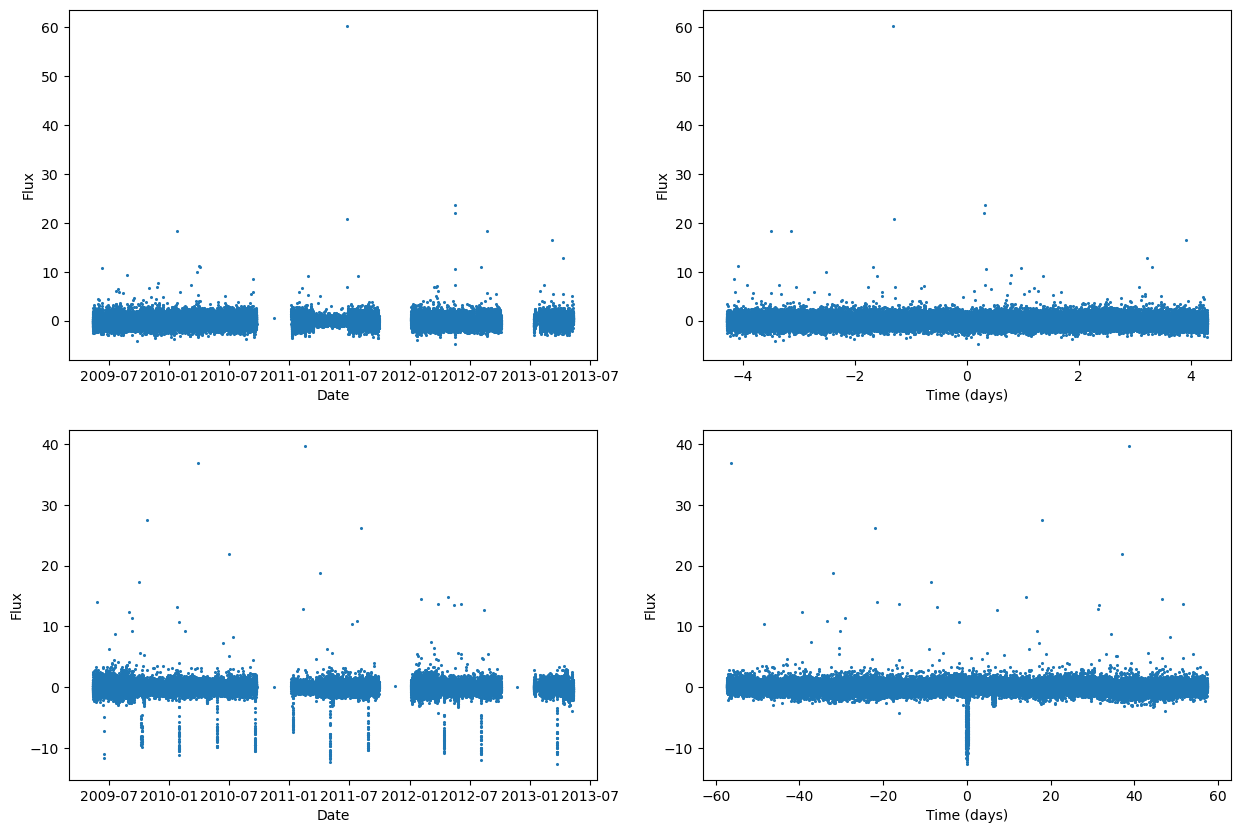

In [10]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.scatter(Ts2.time.datetime, Ts2['flux'], s=1.5)
plt.xlabel('Date')
plt.ylabel('Flux')

plt.subplot(2,2,2)
plt.scatter(TsFolded2.time.jd, TsFolded2['flux'], s=1.5)
plt.xlabel('Time (days)')
plt.ylabel('Flux')

plt.subplot(2,2,3)
plt.scatter(Ts1.time.datetime, Ts1['flux'], s=1.5)
plt.xlabel('Date')
plt.ylabel('Flux')

plt.subplot(2,2,4)
plt.scatter(TsFolded1.time.jd, TsFolded1['flux'], s=1.5)
plt.xlabel('Time (days)')
plt.ylabel('Flux')

plt.show()

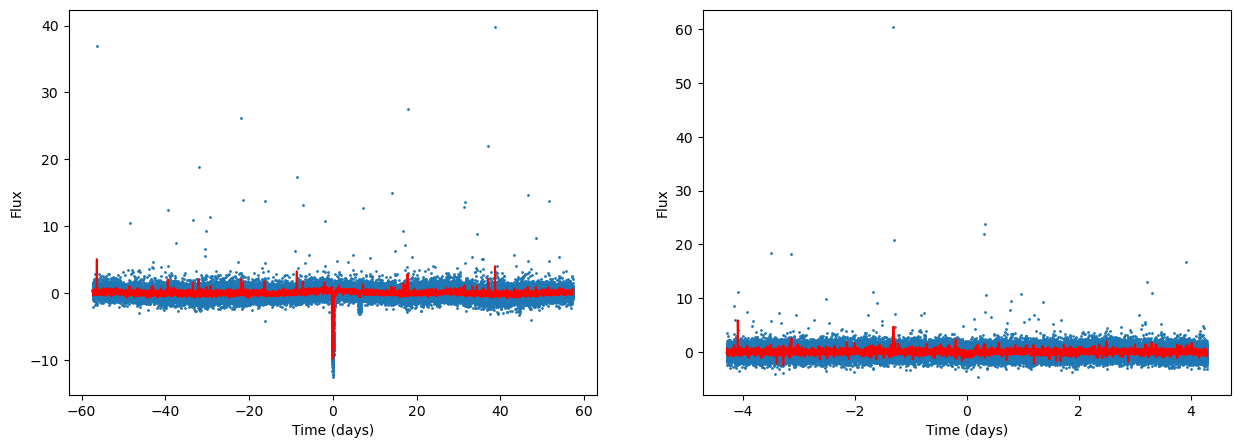

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.scatter(TsFolded1.time.jd, TsFolded1['flux'], s=1)
plt.plot(TsBinned1.time_bin_start.jd, TsBinned1['flux'], 'r-', drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Flux')

plt.subplot(1,2,2)
plt.scatter(TsFolded2.time.jd, TsFolded2['flux'], s=1)
plt.plot(TsBinned2.time_bin_start.jd, TsBinned2['flux'], 'r-', drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Flux')

plt.show()